In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu
from scipy.special import expit as sigmoid

tqdm.pandas()

In [2]:
cis_eQTL = pd.read_csv("~/Downloads/ciseqtl.csv", sep="\t", skiprows=10) # TODO: should also get the trans-eqtl
cis_eQTL

,SNP,Alleles,Alteration number,Gene,Beta,t-stat,p-value,FDR
0,chr4_16921004,G_A,8,AT4G34410,1.521871,10.851752,3.660000e-25,2.220000e-16
1,chr4_16921058,C_T,7,AT4G34410,1.522742,10.075851,3.710000e-22,5.630000e-14
2,chr4_16921082,G_A,7,AT4G34410,1.522742,10.075851,3.710000e-22,5.630000e-14
3,chr4_16921087,G_A,7,AT4G34410,1.522742,10.075851,3.710000e-22,5.630000e-14
4,chr1_4413178,T_G,7,AT1G13310,0.285199,9.702487,9.130000e-21,1.110000e-12
...,...,...,...,...,...,...,...,...
11791,chr5_6992351,G_C,65,AT5G19530,-0.541636,-4.949550,9.690000e-07,4.995519e-02
11792,chr5_5590529,G_A,55,AT5G16180,-0.605012,-4.949497,9.690000e-07,4.996061e-02
11793,chr1_3838815,G_T,122,AT1G13180,-0.398349,-4.949494,9.690000e-07,4.996061e-02
11794,chr1_25212598,T_G,137,AT1G65540,0.404604,4.949454,9.690000e-07,4.996626e-02


In [3]:
#df = pd.read_parquet("../mlm/vep.parquet")
#df = df[df.AN >= 2000]
#df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["alt_AF"] = df.AC / df.AN
#df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
#df["ref_AF"] = 1 - df.alt_AF
#df["alt_AC"] = df.AC
#df["ref_AC"] = df.AN - df.AC
#df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
#df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
#df

In [4]:
#model_name = "DeepSEA"
#model_name = "DNABERT"
model_name = "PlantBert"
df = pd.read_parquet(f"vep_{model_name}.parquet")
pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
df["alt_AF"] = df.AC / df.AN
df["ref_AF"] = 1 - df.alt_AF
df["alt_AC"] = df.AC
df["ref_AC"] = df.AN - df.AC
df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,model_pred_ref_DHS_Ath_flower_14_days,model_pred_ref_DHS_Ath_open_flower_normal,...,model_pred_alt_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,model_pred_alt_TFBS_AT5G65310_Ath_seedling_normal,model_pred_alt_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,model_pred_alt_TFBS_AT5G67300_Ath_seedling_normal,model_pred_alt_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1,alt_AF,ref_AF,alt_AC,ref_AC,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,-7.833055,-11.006874,...,-9.191710,-8.350508,-9.212231,-9.010098,-3.996376,0.180943,0.819057,376,1702,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,-7.762324,-10.840457,...,-9.173491,-8.365861,-9.220976,-8.979354,-3.788191,0.000958,0.999042,2,2086,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,-7.919877,-11.007540,...,-9.282354,-8.497811,-9.287333,-9.109665,-3.855273,0.001896,0.998104,4,2106,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,-7.779240,-10.889699,...,-9.407667,-8.588152,-9.341068,-9.123756,-3.989177,0.002828,0.997172,6,2116,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,-7.724216,-10.851824,...,-9.117188,-8.300213,-9.293217,-9.076027,-3.531540,0.000941,0.999059,2,2124,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Chr5,1770443,G,A,930,2046,AT5G05880.1,795,-1.000630,-4.246535,...,-5.690409,-4.481410,-4.779294,-4.367587,-1.521364,0.545455,0.454545,1116,930,0.454545
99996,Chr5,1770459,A,T,30,2084,AT5G05880.1,811,-1.427556,-4.859993,...,-6.301268,-5.177304,-5.404146,-5.030910,-1.701409,0.014395,0.985605,30,2054,0.014395
99997,Chr5,1770460,T,G,20,2074,AT5G05880.1,812,-1.674408,-5.185572,...,-6.697075,-5.595312,-5.711658,-5.289640,-1.617076,0.009643,0.990357,20,2054,0.009643
99998,Chr5,1770613,G,C,2,2002,AT5G05880.1,965,-4.271122,-8.788689,...,-8.234333,-6.939182,-7.375804,-7.176950,-2.398855,0.000999,0.999001,2,2000,0.000999


In [5]:
df[pred_cols] = sigmoid(df[pred_cols])

(array([7842676.,  738984.,  421875.,  276004.,  214860.,  188749.,
         178948.,  183361.,  223531.,  630576.]),
 array([6.69940809e-08, 9.99995986e-02, 1.99999130e-01, 2.99998662e-01,
        3.99998194e-01, 4.99997725e-01, 5.99997257e-01, 6.99996789e-01,
        7.99996320e-01, 8.99995852e-01, 9.99995384e-01]),
 <BarContainer object of 10 artists>)

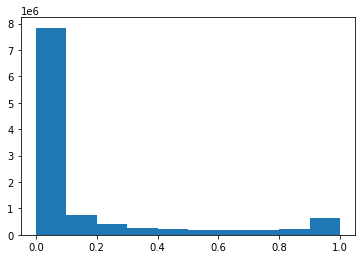

In [6]:
plt.hist(df[pred_alt_cols].values.ravel())

(array([7842676.,  738984.,  421875.,  276004.,  214860.,  188749.,
         178948.,  183361.,  223531.,  630576.]),
 array([6.69940809e-08, 9.99995986e-02, 1.99999130e-01, 2.99998662e-01,
        3.99998194e-01, 4.99997725e-01, 5.99997257e-01, 6.99996789e-01,
        7.99996320e-01, 8.99995852e-01, 9.99995384e-01]),
 <BarContainer object of 10 artists>)

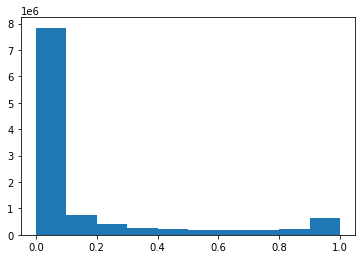

In [7]:
plt.hist(df[pred_alt_cols].values.ravel())

In [8]:
feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
#df.loc[:, delta_pred_cols] = df[pred_ref_cols].values - df[pred_alt_cols].values

df[delta_pred_cols] = df[delta_pred_cols].abs()
df[delta_pred_cols]

,delta_pred_DHS_Ath_flower_14_days,delta_pred_DHS_Ath_open_flower_normal,delta_pred_DHS_Ath_inflorescence_normal,delta_pred_DHS_Ath_leaf_normal,delta_pred_DHS_Ath_root_normal,delta_pred_DHS_Ath_root_7_days,delta_pred_DHS_Ath_root_hair_7_days,delta_pred_DHS_Ath_root_non_hair_7_days,delta_pred_DHS_Ath_root_non_hair_10_days,delta_pred_DHS_Ath_seed_coat_4_days_past_anthesis_rep1,...,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep2,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep3,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep4,delta_pred_TFBS_AT5G63790_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G63790_Ath_seedling_normal,delta_pred_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G65310_Ath_seedling_normal,delta_pred_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G67300_Ath_seedling_normal,delta_pred_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1
0,0.000020,6.704087e-07,0.000019,0.000037,0.001427,0.000035,0.000003,0.000002,9.229717e-07,0.000028,...,0.001750,0.000013,0.000040,0.000004,0.000003,0.000001,2.634979e-08,3.263406e-06,0.000004,0.001184
1,0.000011,7.047689e-07,0.000034,0.000045,0.000165,0.000190,0.000067,0.000017,2.537698e-06,0.000004,...,0.001511,0.000275,0.000079,0.000015,0.000011,0.000004,1.203066e-05,3.762648e-07,0.000008,0.002619
2,0.000027,9.392423e-07,0.000023,0.000092,0.001740,0.000041,0.000019,0.000005,3.794939e-06,0.000015,...,0.002037,0.001236,0.000107,0.000012,0.000009,0.000004,5.650573e-06,7.674174e-06,0.000006,0.000999
3,0.000053,5.012943e-06,0.000094,0.000044,0.001141,0.000208,0.000057,0.000026,3.769745e-05,0.000096,...,0.006438,0.001375,0.000257,0.000016,0.000020,0.000009,1.721768e-05,1.689549e-06,0.000003,0.003553
4,0.000101,1.026124e-06,0.000006,0.000258,0.004744,0.000044,0.000025,0.000015,2.006567e-05,0.000001,...,0.004075,0.001317,0.000320,0.000008,0.000005,0.000002,7.117000e-06,5.629031e-06,0.000013,0.001274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.115864,4.101073e-03,0.018406,0.058484,0.083853,0.002495,0.000612,0.001678,7.628648e-03,0.076942,...,0.009383,0.015419,0.031161,0.000043,0.000080,0.001317,4.290514e-03,3.206705e-03,0.004734,0.004754
99996,0.002807,1.162659e-03,0.010394,0.002940,0.004233,0.001931,0.000085,0.000296,2.224476e-03,0.007084,...,0.001551,0.001877,0.000295,0.000061,0.000091,0.000109,6.190630e-04,9.724142e-04,0.001710,0.029191
99997,0.007922,2.206481e-03,0.004584,0.001350,0.010646,0.002726,0.000691,0.000990,3.835676e-03,0.118868,...,0.001968,0.000238,0.006194,0.000052,0.000062,0.000247,6.399791e-04,6.997296e-04,0.001148,0.040327
99998,0.010033,8.174458e-05,0.004004,0.020274,0.010834,0.000439,0.000171,0.000215,1.034407e-03,0.002419,...,0.001897,0.003807,0.014039,0.000068,0.000068,0.000077,2.778380e-04,1.729374e-04,0.000200,0.027361


In [9]:
df[delta_pred_cols].std()

delta_pred_DHS_Ath_flower_14_days                                                 0.036637
delta_pred_DHS_Ath_open_flower_normal                                             0.027776
delta_pred_DHS_Ath_inflorescence_normal                                           0.024781
delta_pred_DHS_Ath_leaf_normal                                                    0.032318
delta_pred_DHS_Ath_root_normal                                                    0.032792
                                                                                    ...   
delta_pred_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h                       0.037990
delta_pred_TFBS_AT5G65310_Ath_seedling_normal                                     0.038225
delta_pred_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h                       0.032760
delta_pred_TFBS_AT5G67300_Ath_seedling_normal                                     0.029873
delta_pred_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1    0.022553

In [10]:
# normalization
#df[pred_cols] = df[pred_cols] / df[pred_cols].abs().max()
#df[pred_cols] = df[pred_cols] / df[pred_cols].abs().quantile(0.99)
#df[pred_cols] = df[pred_cols] / df[pred_cols].abs().quantile(0.75)

In [11]:
#df[pred_cols].std()

In [12]:
df.AC.value_counts()

2       39008
4       10387
6        5383
8        3634
10       2825
        ...  
1084        2
1108        2
1114        1
1102        1
1106        1
Name: AC, Length: 554, dtype: int64

In [13]:
df[["AN", "AC", "AF"]].describe()

,AN,AC,AF
count,99996.000000,99996.000000,99996.000000
mean,2178.436977,74.742990,0.034711
std,61.213679,183.221915,0.085421
min,2000.000000,2.000000,0.000882
25%,2144.000000,2.000000,0.000917
50%,2196.000000,6.000000,0.002676
75%,2226.000000,34.000000,0.016053
max,2270.000000,1114.000000,0.500000


In [14]:
values = df[delta_pred_cols].values
#df.loc[:, "delta_pred_l1_norm"] = np.linalg.norm(values, ord=1, axis=1)
df.loc[:, "delta_pred_l2_norm"] = np.linalg.norm(values, ord=2, axis=1)
#df.loc[:, "delta_pred_linf_norm"] = np.linalg.norm(values, ord=np.inf, axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,model_pred_ref_DHS_Ath_flower_14_days,model_pred_ref_DHS_Ath_open_flower_normal,...,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep3,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep4,delta_pred_TFBS_AT5G63790_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G63790_Ath_seedling_normal,delta_pred_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G65310_Ath_seedling_normal,delta_pred_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G67300_Ath_seedling_normal,delta_pred_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1,delta_pred_l2_norm
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,0.000396,0.000017,...,0.000013,0.000040,0.000004,0.000003,0.000001,2.634979e-08,3.263406e-06,0.000004,0.001184,0.019949
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,0.000425,0.000020,...,0.000275,0.000079,0.000015,0.000011,0.000004,1.203066e-05,3.762648e-07,0.000008,0.002619,0.030039
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,0.000363,0.000017,...,0.001236,0.000107,0.000012,0.000009,0.000004,5.650573e-06,7.674174e-06,0.000006,0.000999,0.020455
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,0.000418,0.000019,...,0.001375,0.000257,0.000016,0.000020,0.000009,1.721768e-05,1.689549e-06,0.000003,0.003553,0.021950
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,0.000442,0.000019,...,0.001317,0.000320,0.000008,0.000005,0.000002,7.117000e-06,5.629031e-06,0.000013,0.001274,0.045803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Chr5,1770443,G,A,930,2046,AT5G05880.1,795,0.268818,0.014112,...,0.015419,0.031161,0.000043,0.000080,0.001317,4.290514e-03,3.206705e-03,0.004734,0.004754,0.279232
99996,Chr5,1770459,A,T,30,2084,AT5G05880.1,811,0.193480,0.007691,...,0.001877,0.000295,0.000061,0.000091,0.000109,6.190630e-04,9.724142e-04,0.001710,0.029191,0.156971
99997,Chr5,1770460,T,G,20,2074,AT5G05880.1,812,0.157837,0.005566,...,0.000238,0.006194,0.000052,0.000062,0.000247,6.399791e-04,6.997296e-04,0.001148,0.040327,0.296449
99998,Chr5,1770613,G,C,2,2002,AT5G05880.1,965,0.013774,0.000152,...,0.003807,0.014039,0.000068,0.000068,0.000077,2.778380e-04,1.729374e-04,0.000200,0.027361,0.105511


In [15]:
#delta_norm = "delta_pred_l1_norm"
delta_norm = "delta_pred_l2_norm"
#delta_norm = "delta_pred_linf_norm"
#delta_norm = "model_llr"

In [16]:
df["SNP_matching_id"] = df.chromosome.str.lower() + "_" + (df.pos+1).astype(str)
df["eQTL"] = df.SNP_matching_id.isin(cis_eQTL.SNP.values)
df.eQTL.value_counts()
# TODO: should match AF in eQTL and noneQTL to be compared

False    99910
True        86
Name: eQTL, dtype: int64

In [17]:
df["Singleton"] = df.AC == 2
df.Singleton.value_counts()

False    60988
True     39008
Name: Singleton, dtype: int64

In [18]:
#df["logAF"] = np.log(df.AF)
#sns.histplot(data=df, x="logAF", y="delta_pred_l2_norm", bins=300)

In [19]:
#df["logAF_bin"] = pd.cut(df.logAF, 5)

In [20]:
spearmanr(df.AC, df[delta_norm])

SpearmanrResult(correlation=-0.021526185893670058, pvalue=9.91402588528251e-12)

In [21]:
df.AC.max()

1114

In [22]:
df["AC_bin"] = pd.cut(df.AC, [0.0, 2.0, 10.0, 100.0, 300.0, 1115.0])
df.AC_bin.value_counts()

(0.0, 2.0]         39008
(10.0, 100.0]      23314
(2.0, 10.0]        22229
(300.0, 1115.0]     8180
(100.0, 300.0]      7265
Name: AC_bin, dtype: int64

In [23]:
global_percentile_99 = np.percentile(df[delta_norm], 99)
global_percentile_1 = np.percentile(df[delta_norm], 1)
global_percentile_1, global_percentile_99

(0.021450420321994883, 1.1714819916253574)

In [24]:
category = "AC_bin"
#category = "logAF_bin"
#category = "Singleton"
#category = "eQTL"

<AxesSubplot:xlabel='AC_bin', ylabel='Above_99_percentile_delta_norm'>

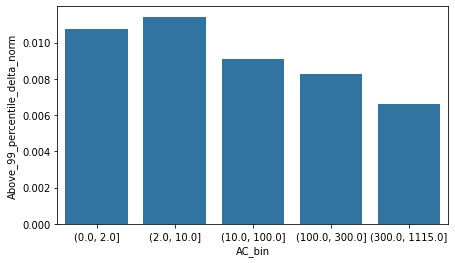

In [25]:
df["Above_99_percentile_delta_norm"] = df[delta_norm] > global_percentile_99
df2 = df.groupby(category)["Above_99_percentile_delta_norm"].mean().to_frame().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=df2, x=category, y="Above_99_percentile_delta_norm", color="C0")
# TODO: could plot a horizontal line at 1 percent. also express it as 1 percent instead of 0.01

In [26]:
#df["below_1_percentile_delta_norm"] = df[delta_norm] < global_percentile_1
#df2 = df.groupby(category)["below_1_percentile_delta_norm"].mean().to_frame().reset_index()
#plt.figure(figsize=(7, 4))
#sns.barplot(data=df2, x=category, y="below_1_percentile_delta_norm", color="C0")

In [27]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

percentiles = [95, 99, 99.9]

groupby = df.groupby(category)[delta_norm].agg([percentile(p) for p in percentiles])
#print(groupby)
x = groupby.melt(ignore_index=False).reset_index()
x

,AC_bin,variable,value
0,"(0.0, 2.0]",percentile_95,0.686162
1,"(2.0, 10.0]",percentile_95,0.676030
2,"(10.0, 100.0]",percentile_95,0.642967
3,"(100.0, 300.0]",percentile_95,0.615245
4,"(300.0, 1115.0]",percentile_95,0.602428
5,"(0.0, 2.0]",percentile_99,1.196698
6,"(2.0, 10.0]",percentile_99,1.227237
7,"(10.0, 100.0]",percentile_99,1.132828
8,"(100.0, 300.0]",percentile_99,1.108547
9,"(300.0, 1115.0]",percentile_99,1.053223


<AxesSubplot:xlabel='variable', ylabel='value'>

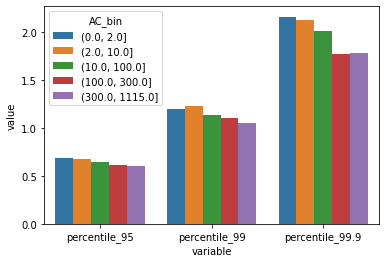

In [28]:
sns.barplot(data=x, x="variable", y="value", hue=category)

(0.95, 1.0)

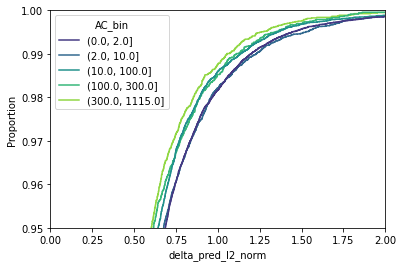

In [29]:
sns.ecdfplot(data=df, x=delta_norm, hue=category, palette="viridis")
plt.xlim([0, 2])
plt.ylim([0.95, 1.0])

(0.4, 0.6)

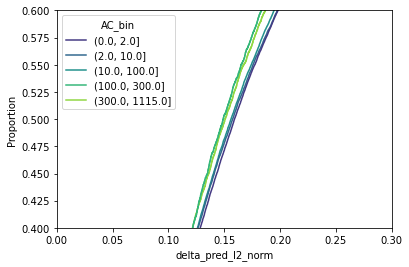

In [30]:
sns.ecdfplot(data=df, x=delta_norm, hue=category, palette="viridis")
plt.xlim([0, 0.3])
plt.ylim([0.4, 0.6])

In [31]:
df_eQTL = df[df.eQTL]
df_eQTL = df_eQTL.merge(cis_eQTL, how="left", left_on="SNP_matching_id", right_on="SNP").sort_values(["chromosome", "pos"])
df_eQTL

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,model_pred_ref_DHS_Ath_flower_14_days,model_pred_ref_DHS_Ath_open_flower_normal,...,AC_bin,Above_99_percentile_delta_norm,SNP,Alleles,Alteration number,Gene,Beta,t-stat,p-value,FDR
0,Chr5,75972,T,C,240,2060,AT5G01200.1,-1144,0.030888,0.006122,...,"(100.0, 300.0]",False,chr5_75973,T_C,84,AT5G02920,0.447839,5.390654,1.010000e-07,0.015674
1,Chr5,144639,C,G,236,2036,AT5G01340.1,81,0.639854,0.009900,...,"(100.0, 300.0]",False,chr5_144640,C_G,67,AT5G01330,0.468163,5.581416,3.620000e-08,0.008654
2,Chr5,170978,T,A,132,2182,AT5G01400.1,94,0.006076,0.000030,...,"(100.0, 300.0]",False,chr5_170979,T_A,42,AT5G04210,0.299652,4.995043,7.730000e-07,0.044936
3,Chr5,171026,C,T,114,2158,AT5G01400.1,46,0.003878,0.000047,...,"(100.0, 300.0]",False,chr5_171027,C_T,25,AT5G03010,0.449628,5.018060,6.900000e-07,0.042525
4,Chr5,337015,A,C,220,2236,AT5G01870.1,-162,0.203202,0.007505,...,"(100.0, 300.0]",False,chr5_337016,A_C,79,AT5G04210,0.228892,5.070060,5.310000e-07,0.037243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Chr5,1743670,G,A,140,2244,AT5G05800.1,1575,0.023994,0.000389,...,"(100.0, 300.0]",False,chr5_1743671,G_A,44,AT5G04260,0.627871,5.271497,1.890000e-07,0.021999
88,Chr5,1743929,G,A,138,2240,AT5G05800.1,1316,0.001580,0.000067,...,"(100.0, 300.0]",False,chr5_1743930,G_A,43,AT5G04260,0.653611,5.451066,7.340000e-08,0.013212
89,Chr5,1743929,G,A,138,2240,AT5G05800.1,1316,0.001580,0.000067,...,"(100.0, 300.0]",False,chr5_1743930,G_A,43,AT5G05090,0.581450,5.327359,1.410000e-07,0.018790
90,Chr5,1745357,T,C,496,2134,AT5G05800.1,-112,0.993544,0.960149,...,"(300.0, 1115.0]",False,chr5_1745358,T_C,151,AT5G05090,0.323388,5.046123,5.990000e-07,0.039580


<AxesSubplot:xlabel='Beta', ylabel='delta_pred_l2_norm'>

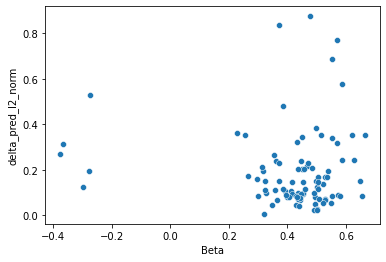

In [32]:
sns.scatterplot(data=df_eQTL, x="Beta", y=delta_norm)

<AxesSubplot:xlabel='p-value', ylabel='delta_pred_l2_norm'>

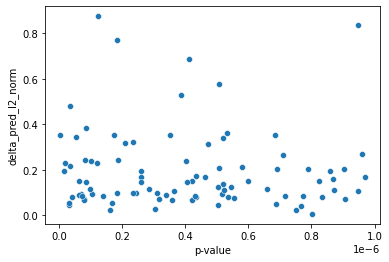

In [33]:
sns.scatterplot(data=df_eQTL, x="p-value", y=delta_norm)

<AxesSubplot:xlabel='t-stat', ylabel='delta_pred_l2_norm'>

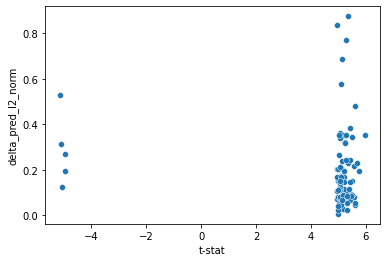

In [34]:
sns.scatterplot(data=df_eQTL, x="t-stat", y=delta_norm)

<AxesSubplot:xlabel='abs_t-stat', ylabel='delta_pred_l2_norm'>

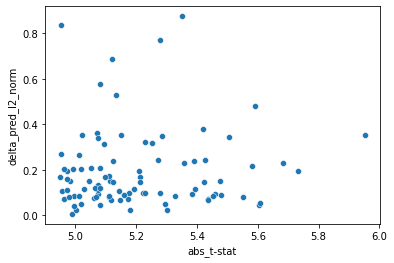

In [35]:
df_eQTL["abs_t-stat"] = df_eQTL["t-stat"].abs()
sns.scatterplot(data=df_eQTL, x="abs_t-stat", y=delta_norm)

In [36]:
spearmanr(df_eQTL["abs_t-stat"], df_eQTL[delta_norm])

SpearmanrResult(correlation=0.043595029388689914, pvalue=0.6798792609661863)

In [37]:
mannwhitneyu(
    df_eQTL.loc[df_eQTL.Beta.abs() < 0.5, delta_norm],
    df_eQTL.loc[df_eQTL.Beta.abs() >= 0.5, delta_norm],
    alternative="greater")

MannwhitneyuResult(statistic=900.5, pvalue=0.5986582505393124)

In [38]:
df_eQTL.groupby("closest_TSS").size().nlargest()

closest_TSS
AT5G05610.1    10
AT5G03910.1     9
AT5G05800.1     6
AT5G05580.2     4
AT5G03795.1     3
dtype: int64

In [39]:
df_locus = df_eQTL[df_eQTL.closest_TSS=="AT5G63570.1"]

<AxesSubplot:>

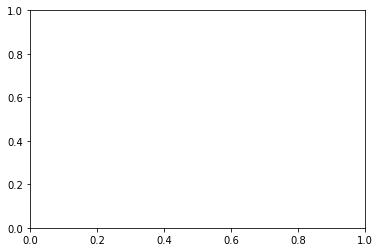

In [40]:
sns.lineplot(data=df_locus, x="dist_to_TSS", y=delta_norm)

<AxesSubplot:>

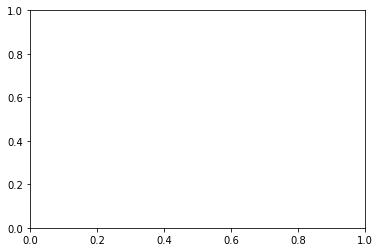

In [41]:
sns.lineplot(data=df_locus, x="dist_to_TSS", y="t-stat", ci=None)

<AxesSubplot:>

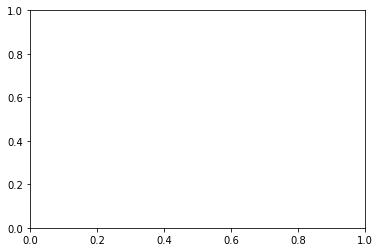

In [42]:
sns.lineplot(data=df_locus, x="dist_to_TSS", y="Beta", ci=None)

In [43]:
spearmanr(df_locus["abs_t-stat"], df_locus[delta_norm])

SpearmanrResult(correlation=nan, pvalue=nan)

In [44]:
df["Status"] = "Neither"
df.loc[df.AC <= 10, "Status"] = "Rare"
df.loc[df.AC > 100, "Status"] = "Common"
df.Status.value_counts()

Rare       61237
Neither    23314
Common     15445
Name: Status, dtype: int64

In [45]:
mannwhitneyu(df.loc[df.Status=="Rare", delta_norm], df.loc[df.Status=="Common", delta_norm], alternative="greater")

MannwhitneyuResult(statistic=490729534.0, pvalue=2.0645341215783682e-13)

In [46]:
# this should work with the latest scipy
#mannwhitneyu(df.loc[df.Status=="Rare", delta_pred_cols], df.loc[df.Status=="Common", delta_pred_cols], alternative="greater")

In [47]:
p_values = np.array([
    mannwhitneyu(
        df.loc[df.Status=="Rare", delta_pred_col],
        df.loc[df.Status=="Common", delta_pred_col],
        alternative="greater"
        #"two-sided",
    ).pvalue
    for delta_pred_col in delta_pred_cols
])
p_values

array([1.10842203e-14, 1.27306796e-30, 5.62982730e-31, 7.36252088e-01,
       1.77862292e-04, 6.60913076e-31, 1.18299374e-28, 5.81770851e-16,
       1.67467548e-02, 1.02688084e-38, 1.97707220e-22, 1.02714245e-32,
       1.16618141e-16, 9.81628157e-01, 2.25418554e-18, 1.88200049e-15,
       2.05408835e-22, 5.61362898e-18, 3.16530101e-05, 5.22747840e-41,
       8.35560980e-38, 1.02607024e-35, 5.08661739e-39, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99999975e-01,
       9.99999998e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 7.54779664e-01, 8.67208918e-01, 3.04922300e-01,
       1.00000000e+00, 1.35123276e-09, 8.40861567e-01, 2.24557918e-08,
       9.99999999e-01, 9.96963870e-01, 1.09132658e-03, 1.49487045e-44,
       5.82185115e-20, 1.32521675e-24, 5.90991410e-22, 1.07503533e-22,
       2.57315356e-11, 9.57270959e-08, 1.34626883e-04, 2.23035526e-10,
       5.69048076e-18, 2.04196535e-22, 9.48942588e-23, 2.21726699e-26,
      

In [48]:
p_values.shape

(109,)

In [49]:
p_values_df = pd.DataFrame(data=np.expand_dims(p_values, axis=1), index=np.array(feature_names), columns=["p_value"])
p_values_df["delta_mean"] = (df.loc[df.Status=="Rare", delta_pred_cols].mean() - df.loc[df.Status=="Common", delta_pred_cols].mean()).values
p_values_df

,p_value,delta_mean
DHS_Ath_flower_14_days,1.108422e-14,0.002304
DHS_Ath_open_flower_normal,1.273068e-30,0.001797
DHS_Ath_inflorescence_normal,5.629827e-31,0.001825
DHS_Ath_leaf_normal,7.362521e-01,0.000868
DHS_Ath_root_normal,1.778623e-04,0.001330
...,...,...
TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,1.950060e-37,0.002928
TFBS_AT5G65310_Ath_seedling_normal,2.162717e-31,0.003012
TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,5.992447e-22,0.001773
TFBS_AT5G67300_Ath_seedling_normal,4.408006e-24,0.002078


In [50]:
p_values_df.to_csv(f"p_values_{model_name}.tsv", sep="\t")

In [51]:
model_names = ["DeepSEA", "DNABERT", "PlantBert"]
p_value_dfs = []
for model_name in model_names:
    p_value_df = pd.read_csv(f"p_values_{model_name}.tsv", sep="\t", index_col=0)
    p_value_df.p_value += 1e-300
    print(p_value_df.min())
    p_value_df["minuslog10p"] = -np.log10(p_value_df.p_value)
    p_value_df = p_value_df.add_suffix("_" + model_name)
    p_value_dfs.append(p_value_df)
p_value_df = pd.concat(p_value_dfs, axis=1)
p_value_df["Feature_type"] = p_value_df.index.str.split("_").str[0]
p_value_df

p_value       3.556366e-53
delta_mean   -6.612456e-04
dtype: float64
p_value       5.255922e-48
delta_mean   -7.870939e-04
dtype: float64
p_value       1.494870e-44
delta_mean   -1.297379e-03
dtype: float64


,p_value_DeepSEA,delta_mean_DeepSEA,minuslog10p_DeepSEA,p_value_DNABERT,delta_mean_DNABERT,minuslog10p_DNABERT,p_value_PlantBert,delta_mean_PlantBert,minuslog10p_PlantBert,Feature_type
DHS_Ath_flower_14_days,8.139459e-21,0.001871,20.089404,3.019876e-09,0.001863,8.520011,1.108422e-14,0.002304,13.955295,DHS
DHS_Ath_open_flower_normal,2.951053e-41,0.001685,40.530023,5.163433e-29,0.001836,28.287061,1.273068e-30,0.001797,29.895148,DHS
DHS_Ath_inflorescence_normal,4.484489e-36,0.001505,35.348287,5.046943e-25,0.001877,24.296972,5.629827e-31,0.001825,30.249505,DHS
DHS_Ath_leaf_normal,1.166702e-03,0.001155,2.933040,9.107048e-01,0.000829,0.040622,7.362521e-01,0.000868,0.132973,DHS
DHS_Ath_root_normal,5.053847e-09,0.001201,8.296378,5.226339e-03,0.001002,2.281802,1.778623e-04,0.001330,3.749916,DHS
...,...,...,...,...,...,...,...,...,...,...
TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,1.313737e-43,0.001958,42.881492,1.385204e-23,0.001793,22.858486,1.950060e-37,0.002928,36.709952,TFBS
TFBS_AT5G65310_Ath_seedling_normal,5.624741e-39,0.001880,38.249898,6.823557e-22,0.001829,21.165989,2.162717e-31,0.003012,30.665000,TFBS
TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,7.543776e-30,0.001844,29.122411,3.347116e-14,0.001608,13.475329,5.992447e-22,0.001773,21.222396,TFBS
TFBS_AT5G67300_Ath_seedling_normal,1.348509e-34,0.001676,33.870146,2.834543e-19,0.001762,18.547517,4.408006e-24,0.002078,23.355758,TFBS


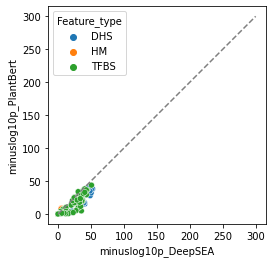

In [52]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 300], [0, 300], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

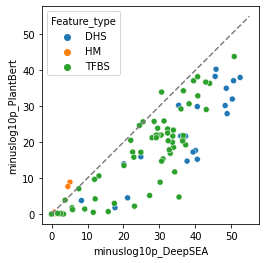

In [63]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")

plt.gca().set_aspect('equal', 'box')

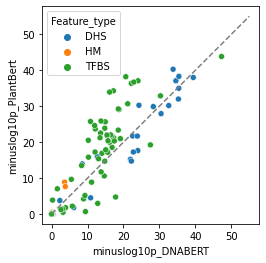

In [62]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DNABERT", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")

plt.gca().set_aspect('equal', 'box')

<AxesSubplot:xlabel='Feature_type', ylabel='minuslog10p_PlantBert'>

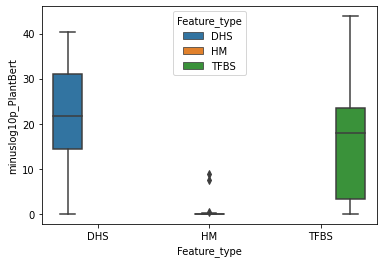

In [55]:
sns.boxplot(data=p_value_df, x="Feature_type", y="minuslog10p_PlantBert", hue="Feature_type")

<AxesSubplot:xlabel='Feature_type', ylabel='minuslog10p_DeepSEA'>

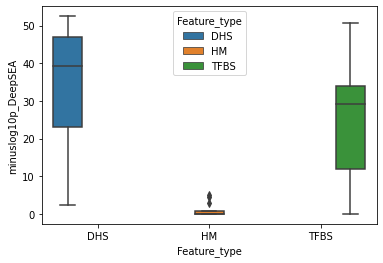

In [60]:
sns.boxplot(data=p_value_df, x="Feature_type", y="minuslog10p_DeepSEA", hue="Feature_type")

<AxesSubplot:xlabel='Feature_type', ylabel='minuslog10p_DNABERT'>

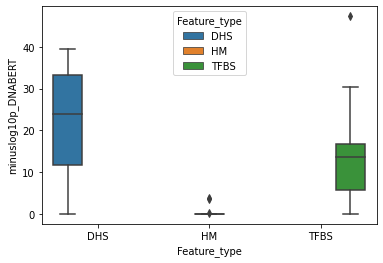

In [61]:
sns.boxplot(data=p_value_df, x="Feature_type", y="minuslog10p_DNABERT", hue="Feature_type")

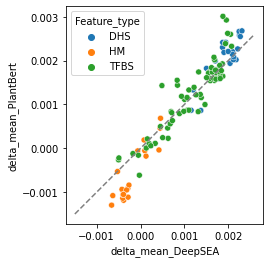

In [56]:
sns.scatterplot(data=p_value_df, x="delta_mean_DeepSEA", y="delta_mean_PlantBert", hue="Feature_type")
plt.plot([-0.0015, 0.0026], [-0.0015, 0.0026], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

<AxesSubplot:xlabel='dist_to_TSS', ylabel='delta_pred_l2_norm'>

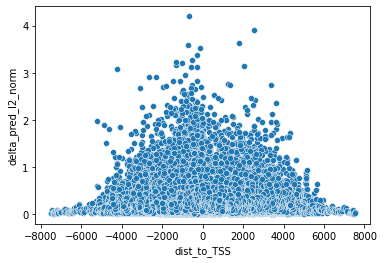

In [57]:
sns.scatterplot(data=df, x="dist_to_TSS", y=delta_norm)

In [58]:
df.dist_to_TSS.describe()

count    99996.000000
mean       382.737309
std       1529.685838
min      -7510.000000
25%       -546.000000
50%        314.000000
75%       1292.000000
max       7536.000000
Name: dist_to_TSS, dtype: float64

<AxesSubplot:>

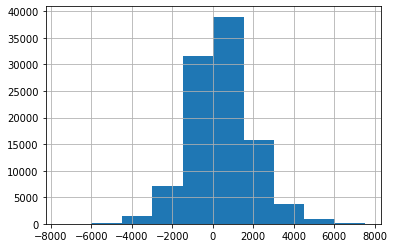

In [59]:
df.dist_to_TSS.hist()